In [1]:
import os
import numpy as np
from scipy.io import loadmat
from scipy import stats
from scipy import signal
import scipy.integrate as integrate
import numpy.polynomial.hermite as herm
from scipy.signal import butter, lfilter, medfilt, resample
import matplotlib.pyplot as plt
import pywt
import scipy.stats

def detect_peaks(ecg_measurements,signal_frequency,gain):

    """
    Method responsible for extracting peaks from loaded ECG measurements data through measurements processing.
    This implementation of a QRS Complex Detector is by no means a certified medical tool and should not be used in health monitoring. 
    It was created and used for experimental purposes in psychophysiology and psychology.
    You can find more information in module documentation:
    https://github.com/c-labpl/qrs_detector
    If you use these modules in a research project, please consider citing it:
    https://zenodo.org/record/583770
    If you use these modules in any other project, please refer to MIT open-source license.
    If you have any question on the implementation, please refer to:
    Michal Sznajder (Jagiellonian University) - technical contact (msznajder@gmail.com)
    Marta lukowska (Jagiellonian University)
    Janko Slavic peak detection algorithm and implementation.
    https://github.com/c-labpl/qrs_detector
    https://github.com/jankoslavic/py-tools/tree/master/findpeaks
    
    MIT License
    Copyright (c) 2017 Michal Sznajder, Marta Lukowska

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.
    """


    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1
    integration_window = 30  # Change proportionally when adjusting frequency (in samples).
    findpeaks_limit = 0.35
    findpeaks_spacing = 100  # Change proportionally when adjusting frequency (in samples).
    refractory_period = 240  # Change proportionally when adjusting frequency (in samples).
    qrs_peak_filtering_factor = 0.125
    noise_peak_filtering_factor = 0.125
    qrs_noise_diff_weight = 0.25


    # Detection results.
    qrs_peaks_indices = np.array([], dtype=int)
    noise_peaks_indices = np.array([], dtype=int)


    # Measurements filtering - 0-15 Hz band pass filter.
    filtered_ecg_measurements = bandpass_filter(ecg_measurements, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=signal_frequency, filter_order=filter_order)

    filtered_ecg_measurements[:5] = filtered_ecg_measurements[5]

    # Derivative - provides QRS slope information.
    differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)

    # Squaring - intensifies values received in derivative.
    squared_ecg_measurements = differentiated_ecg_measurements ** 2

    # Moving-window integration.
    integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window)/integration_window)

    # Fiducial mark - peak detection on integrated measurements.
    detected_peaks_indices = findpeaks(data=integrated_ecg_measurements,
                                                    limit=findpeaks_limit,
                                                    spacing=findpeaks_spacing)

    detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]

    return detected_peaks_values,detected_peaks_indices
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
    """
    Method responsible for creating and applying Butterworth filter.
    :param deque data: raw data
    :param float lowcut: filter lowcut frequency value
    :param float highcut: filter highcut frequency value
    :param int signal_freq: signal frequency in samples per second (Hz)
    :param int filter_order: filter order
    :return array: filtered data
    """
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y



def findpeaks(data, spacing=1, limit=None):
    """
    Janko Slavic peak detection algorithm and implementation.
    https://github.com/jankoslavic/py-tools/tree/master/findpeaks
    Finds peaks in `data` which are of `spacing` width and >=`limit`.
    :param ndarray data: data
    :param float spacing: minimum spacing to the next peak (should be 1 or more)
    :param float limit: peaks should have value greater or equal
    :return array: detected peaks indexes array
    """
    len = data.size
    x = np.zeros(len + 2 * spacing)
    x[:spacing] = data[0] - 1.e-6
    x[-spacing:] = data[-1] - 1.e-6
    x[spacing:spacing + len] = data
    peak_candidate = np.zeros(len)
    peak_candidate[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + len]  # before
        start = spacing
        h_c = x[start: start + len]  # central
        start = spacing + s + 1
        h_a = x[start: start + len]  # after
        peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

    ind = np.argwhere(peak_candidate)
    ind = ind.reshape(ind.size)
    if limit is not None:
        ind = ind[data[ind] > limit]
    return ind

def load_challenge_data(filename):

    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)

    new_file = filename.replace('.mat', '.hea')
    input_header_file = os.path.join(new_file)

    with open(input_header_file, 'r') as f:
        header_data = f.readlines()

    return data, header_data


In [2]:
nSamples = 6877;
# Components of interest
components = [3, 4, 5, 6, 7, 8];
nComponents = len(components);
nLeads = 12
nLevels = 8
nRRFeaturesPerLead = 4
# For each component, extract 2nd, 3rd and fourth order cumulants at 0
nHOSFeaturesPerLead = 3*nComponents;
# Total number of features per lead
nFeaturesPerLead = nRRFeaturesPerLead + nHOSFeaturesPerLead;
# Total number of feautres for each example. Add 2 for age and sex
nFeatures = nFeaturesPerLead * nLeads + 2;

In [3]:
data, header_data = load_challenge_data('input/PhysioNetChallenge2020_Training_CPSC/test/A0001.mat')

In [4]:
tmp_hea = header_data[0].split(' ')
ptID = tmp_hea[0]
num_leads = int(tmp_hea[1])
sample_Fs= int(tmp_hea[2])
gain_lead = np.zeros(num_leads)
for ii in range(num_leads):
    tmp_hea = header_data[ii+1].split(' ')
    gain_lead[ii] = int(tmp_hea[2].split('/')[0])
# for testing, we included the mean age of 57 if the age is a NaN
# This value will change as more data is being released
for iline in header_data:
    if iline.startswith('#Age'):
        tmp_age = iline.split(': ')[1].strip()
        age = int(tmp_age if tmp_age != 'NaN' else 57)
    elif iline.startswith('#Sex'):
        tmp_sex = iline.split(': ')[1]
        if tmp_sex.strip()=='Female':
            sex =1
        else:
            sex=0
    elif iline.startswith('#Dx'):
        label = iline.split(': ')[1].split(',')[0]

# RR features for each lead
RRFeatures = np.zeros((nLeads, nRRFeaturesPerLead));
# For each lead, we extract 3 HOS features from each subband
HOSFeaturesAll = np.zeros((nLeads, nHOSFeaturesPerLead));
# Put together HOS, RR + age + sex
featuresAll = np.zeros(( nFeatures, 1));

for iLead in range(nLeads):
    x = data[iLead, :]

    mra = pywt.wavedec(x, 'sym4', level=nLevels)
    
    # 2nd, 3rd and 4th order cumulants at 0 for each level
    HOSFeatures = np.zeros((3*nComponents, ));
    for iLevel in range(nComponents):
        y = mra[components[iLevel]]

        threshold = 50
        ythard = pywt.threshold(y, threshold, 'hard')

        stdV      = np.std(ythard)
        skewnessV = scipy.stats.skew(ythard)
        kurtosisV = scipy.stats.kurtosis(ythard)

        HOSFeatures[3*iLevel] = stdV;
        HOSFeatures[3*iLevel + 1] = skewnessV;
        HOSFeatures[3*iLevel + 2] = kurtosisV;
    HOSFeaturesAll[iLead, :] = HOSFeatures

    peaks, R_index = detect_peaks(x, sample_Fs, gain_lead[0])
    # RR intervals time series
    rr = np.diff(R_index)
    # First differences of time series
    drr = np.diff(rr)
    RRFeatures[iLead, 0] = np.mean(rr)
    RRFeatures[iLead, 1] = np.std(rr)
    RRFeatures[iLead, 2] = np.sqrt( np.sum( np.power(drr, 2) )/len(drr) )
    RRFeatures[iLead, 3] = np.std(drr)
    
featuresAll[ 0:nLeads*nHOSFeaturesPerLead ] = HOSFeaturesAll.reshape(nLeads*nHOSFeaturesPerLead, 1)
featuresAll[ nLeads*nHOSFeaturesPerLead + 1 : nLeads*nHOSFeaturesPerLead + nLeads*nRRFeaturesPerLead + 1 ] = RRFeatures.reshape(nLeads*nRRFeaturesPerLead, 1);
featuresAll[-2] = sex;
featuresAll[-1] = age;

In [53]:
coeffs = pywt.wavedec(x, 'sym4', level=nLevels)

In [54]:
len(coeffs)

9

In [60]:
coeffs[0] = np.zeros_like(coeffs[0])

In [61]:
# coeffs[1] = np.zeros_like(coeffs[1])

In [62]:
coeffs[-1] = np.zeros_like(coeffs[-1])

In [63]:
xrec = pywt.waverec(coeffs, 'sym4')

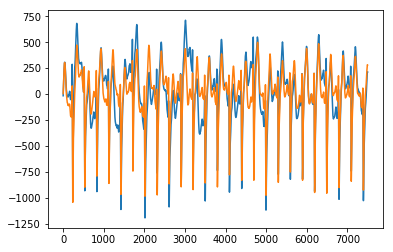

In [64]:
plt.plot(x)
plt.plot(xrec)
plt.show()